# Importación scripts y librerías

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from datetime import date
from datetime import datetime
import time
import os
import pickle
import sys

import json

import pandas as pd
from contextlib import redirect_stdout
import re
import matplotlib.pyplot as plt
import numpy as np

parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from scripts import dl_utils
from scripts import viz_tools
from scripts import models

import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

2024-10-01 16:53:49.321214: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 16:53:49.486921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 16:53:49.486954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 16:53:49.515404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 16:53:49.572450: I tensorflow/core/platform/cpu_feature_guar

# Visualización de las Métricas generales

In [2]:
with open('../notebooks/resultados/checkpoint_resultados.pkl', 'rb') as file:
    model_data_list = pickle.load(file)

## Visualización del Tiempo de inferencia (s), Num épocas entrenamiento y Tiempo entrenamiento (s)

In [9]:
rows = []
for elem in model_data_list:
    rows.append([elem[0],elem[2][-1],round(elem[2][-2]),round(elem[2][-2]/elem[2][-1],3)])
columns = ["Nombre del modelo","Num épocas entrenamiento","Tiempo entrenamiento (s)","Tiempo por época (s)"]
df = pd.DataFrame(rows, columns=columns)
df_sorted = df.sort_values(by="Tiempo entrenamiento (s)", ascending=False)
display(df_sorted)

,Nombre del modelo,Num épocas entrenamiento,Tiempo entrenamiento (s),Tiempo por época (s)
2,Scratch Modified Model,127,446,3.515
0,Base Model,160,436,2.726
4,VGG16 con GlobalMaxPooling,102,368,3.609
7,MobileNet con GlobalMaxPooling,99,361,3.651
1,AlexNet,101,358,3.547
5,VGG16 con GlobalAveragePooling,84,303,3.610
3,VGG16 con Flatten,60,220,3.669
6,MobileNet con Flatten,58,212,3.661
8,MobileNet con GlobalAveragePooling,40,147,3.682


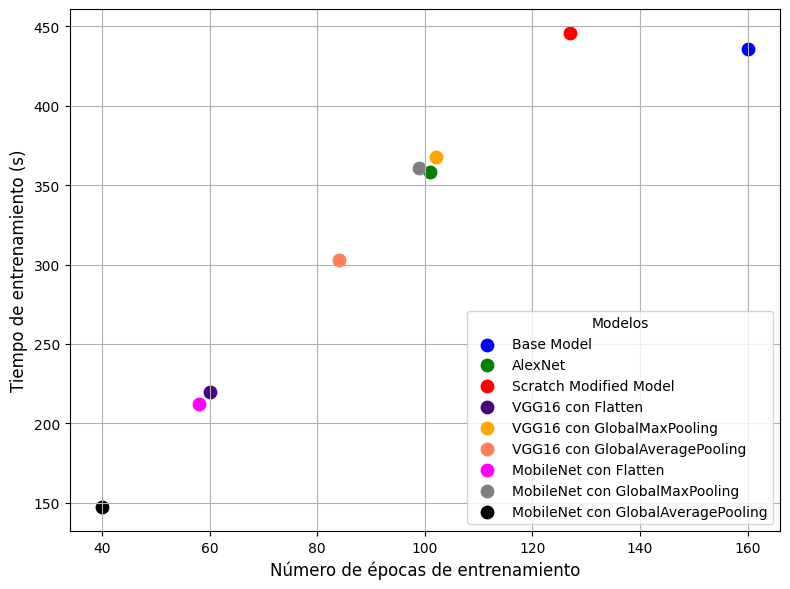

In [5]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes
plt.figure(figsize=(8, 6))

# Asignar un color diferente para cada modelo
colors = ['blue', 'green', 'red', 'Indigo', 'orange', 'Coral', 'magenta', 'grey', 'black']

# Graficar cada modelo con un color distinto
for i, model_name in enumerate(df["Nombre del modelo"]):
    plt.scatter(
        df["Num épocas entrenamiento"][i], 
        df["Tiempo entrenamiento (s)"][i], 
        color=colors[i], 
        label=model_name, 
        s=80  # Tamaño de los puntos
    )

# Añadir etiquetas y título
plt.xlabel("Número de épocas de entrenamiento", fontsize=12)
plt.ylabel("Tiempo de entrenamiento (s)", fontsize=12)

# Añadir leyenda en la esquina inferior izquierda
plt.legend(title="Modelos", loc='lower right')

# Mostrar la cuadrícula y gráfica
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualización del macro avg f1-score, precision y recall

In [6]:
rows = []
for elem in model_data_list:
    rows.append([elem[0],
                 elem[3].iloc[3,3],
                 elem[3].iloc[0,3],
                 elem[3].iloc[1,3],
                 elem[3].iloc[0,3]-elem[3].iloc[1,3],
                 elem[3].iloc[0,1],
                 elem[3].iloc[1,1],
                 elem[3].iloc[0,2],
                 elem[3].iloc[1,2]])
columns = ["Nombre del modelo",
           "macro avg f1-score",
           "f1-score clase 0",
           "f1-score clase 1",
           "diff f1-scores",
           "precision clase 0",
           "precision clase 1",
           "recall clase 0",
           "recall clase 1"]
df = pd.DataFrame(rows, columns=columns)
display(df)

,Nombre del modelo,macro avg f1-score,f1-score clase 0,f1-score clase 1,diff f1-scores,precision clase 0,precision clase 1,recall clase 0,recall clase 1
0,Base Model,0.954,0.964,0.944,0.020,0.937,0.988,0.993,0.903
1,AlexNet,0.964,0.970,0.957,0.013,0.974,0.952,0.967,0.962
2,Scratch Modified Model,0.977,0.982,0.973,0.009,0.974,0.983,0.989,0.962
3,VGG16 con Flatten,0.959,0.967,0.951,0.016,0.960,0.961,0.974,0.941
4,VGG16 con GlobalMaxPooling,0.970,0.976,0.965,0.011,0.981,0.957,0.970,0.973
5,VGG16 con GlobalAveragePooling,0.970,0.976,0.964,0.012,0.967,0.978,0.985,0.951
6,MobileNet con Flatten,0.964,0.970,0.957,0.013,0.974,0.952,0.967,0.962
7,MobileNet con GlobalMaxPooling,0.964,0.970,0.958,0.012,0.985,0.938,0.955,0.978
8,MobileNet con GlobalAveragePooling,0.963,0.971,0.956,0.015,0.957,0.977,0.985,0.935


### precision y recall

In [7]:
rows = []
for elem in model_data_list:
    rows.append([elem[0],
                 elem[3].iloc[1,1],
                 elem[3].iloc[1,2],
                 elem[3].iloc[0,1],
                 elem[3].iloc[0,2],
                 elem[3].iloc[3,3]])
columns = ["Nombre del modelo","precision clase 1","recall clase 1","precision clase 0","recall clase 0","macro f1score"]
df = pd.DataFrame(rows, columns=columns)
df_sorted_display = df.sort_values(by=["macro f1score"], ascending=[True])
del df_sorted_display["macro f1score"]
display(df_sorted_display)

,Nombre del modelo,precision clase 1,recall clase 1,precision clase 0,recall clase 0
0,Base Model,0.988,0.903,0.937,0.993
3,VGG16 con Flatten,0.961,0.941,0.960,0.974
8,MobileNet con GlobalAveragePooling,0.977,0.935,0.957,0.985
1,AlexNet,0.952,0.962,0.974,0.967
6,MobileNet con Flatten,0.952,0.962,0.974,0.967
7,MobileNet con GlobalMaxPooling,0.938,0.978,0.985,0.955
4,VGG16 con GlobalMaxPooling,0.957,0.973,0.981,0.970
5,VGG16 con GlobalAveragePooling,0.978,0.951,0.967,0.985
2,Scratch Modified Model,0.983,0.962,0.974,0.989


### f1-score

In [8]:
rows = []
for elem in model_data_list:
    rows.append([elem[0],
                 elem[3].iloc[3,3],
                 elem[3].iloc[1,3],
                 elem[3].iloc[0,3],
                 abs(elem[3].iloc[1,3]-elem[3].iloc[0,3])])
columns = ["Nombre del modelo",
           "macro avg f1-score",
           "f1-score clase 1",
           "f1-score clase 0",
           "Diferencia entre clases"]
df = pd.DataFrame(rows, columns=columns)

df_sorted_display = df.sort_values(by=["macro avg f1-score", "f1-score clase 1", "f1-score clase 0"], ascending=[True,True,True])
display(df_sorted_display)

df_sorted = df.sort_values(by=["macro avg f1-score", "f1-score clase 1", "f1-score clase 0"], ascending=[False, False, False])
df_sorted = df_sorted.reset_index(drop=True)


,Nombre del modelo,macro avg f1-score,f1-score clase 1,f1-score clase 0,Diferencia entre clases
0,Base Model,0.954,0.944,0.964,0.020
3,VGG16 con Flatten,0.959,0.951,0.967,0.016
8,MobileNet con GlobalAveragePooling,0.963,0.956,0.971,0.015
1,AlexNet,0.964,0.957,0.970,0.013
6,MobileNet con Flatten,0.964,0.957,0.970,0.013
7,MobileNet con GlobalMaxPooling,0.964,0.958,0.970,0.012
5,VGG16 con GlobalAveragePooling,0.970,0.964,0.976,0.012
4,VGG16 con GlobalMaxPooling,0.970,0.965,0.976,0.011
2,Scratch Modified Model,0.977,0.973,0.982,0.009


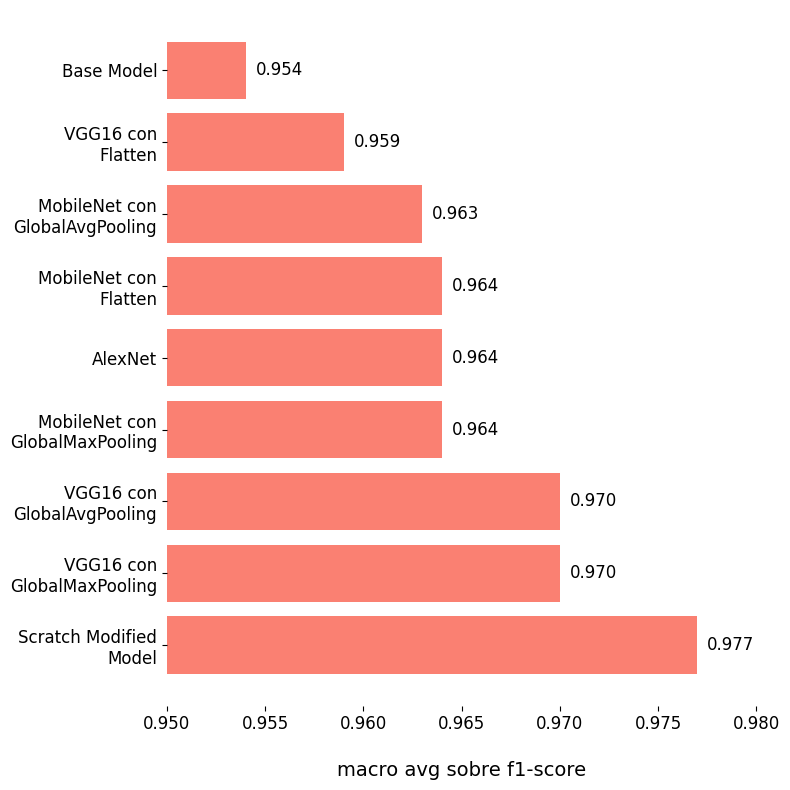

In [9]:
df_sorted["Nombre del modelo"] = ["Scratch Modified\nModel","VGG16 con\nGlobalMaxPooling","VGG16 con\nGlobalAvgPooling","MobileNet con\nGlobalMaxPooling","AlexNet","MobileNet con\nFlatten","MobileNet con\nGlobalAvgPooling","VGG16 con\nFlatten","Base Model"]

fig, ax = plt.subplots(figsize=(8, 8))

# Graficar las barras horizontales para macro avg f1-score
ax.barh(df_sorted["Nombre del modelo"], df_sorted["macro avg f1-score"], color='salmon')

# Añadir etiquetas y título
ax.set_xlabel('macro avg sobre f1-score', labelpad=20, fontsize=14)

ax.tick_params(axis='x', labelsize=12)  # Cambiar el tamaño de los valores del eje X
ax.tick_params(axis='y', labelsize=12)  # Cambiar el tamaño de los valores del eje Y

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ajustar el rango del eje X (puedes modificar los valores si es necesario)
ax.set_xlim(0.95, 0.98)

# Añadir los valores al final de cada barra
for i in range(len(df_sorted)):
    ax.text(df_sorted["macro avg f1-score"].iloc[i] + 0.0005, i, 
            f'{df_sorted["macro avg f1-score"].iloc[i]:.3f}', 
            va='center',ha='left',size=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Visualización del tiempo de inferencia vs número de parámetros entrenables

In [33]:
rows = []
for elem in model_data_list:
    rows.append([elem[0],elem[4][0],round(elem[1]*1000),round((elem[1]/454)*1000,3)])
columns = ["Nombre del modelo","Numero total de parámetros","Tiempo de inferencia (ms)","Tiempo de inferencia por imagen (ms)"]
df = pd.DataFrame(rows, columns=columns)

df_sorted = df.sort_values(by=["Tiempo de inferencia (ms)","Numero total de parámetros"], ascending=[True,True])
display(df_sorted)


,Nombre del modelo,Numero total de parámetros,Tiempo de inferencia (ms),Tiempo de inferencia por imagen (ms)
0,Base Model,116577,108,0.237
5,VGG16 con GlobalAveragePooling,15507841,153,0.336
4,VGG16 con GlobalMaxPooling,15507841,154,0.339
2,Scratch Modified Model,1929281,221,0.487
8,MobileNet con GlobalAveragePooling,4543745,234,0.515
7,MobileNet con GlobalMaxPooling,4543745,246,0.541
1,AlexNet,10427873,279,0.614
3,VGG16 con Flatten,15507841,372,0.820
6,MobileNet con Flatten,12932353,515,1.134


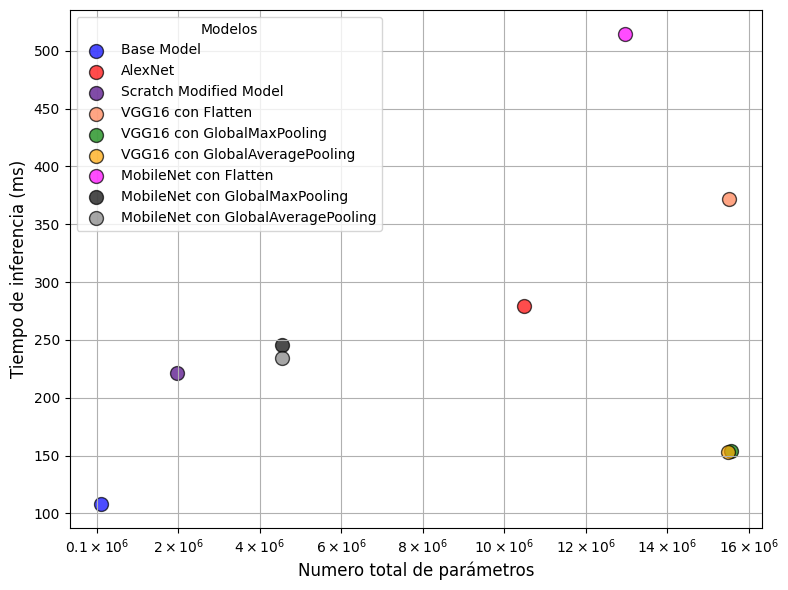

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    if int(value / 10**6) == 0:
        result = 0.1
    else:
        result = int(value / 10**6)
    return r'${}\times10^6$'.format(result)

# Crear la figura y los ejes
plt.figure(figsize=(8, 6))

# Asignar un color diferente para cada modelo
colors = ['blue', 'red', 'Indigo',  'Coral',  'green','orange' ,'magenta', 'black','grey']

# Añadir un poco de jitter (pequeño desplazamiento aleatorio)
jitter_x = np.random.uniform(-0.05e6, 0.05e6, size=len(df))  # Ajusta la cantidad de jitter si es necesario
jitter_y = np.random.uniform(-0.005, 0.005, size=len(df))

# Graficar cada modelo con un color distinto, añadiendo jitter y otros efectos
for i, model_name in enumerate(df["Nombre del modelo"]):
    plt.scatter(
        df["Numero total de parámetros"][i] + jitter_x[i],  # Añadir jitter en el eje X
        df["Tiempo de inferencia (ms)"][i] + jitter_y[i],    # Añadir jitter en el eje Y
        color=colors[i], 
        label=model_name, 
        s=100,  # Aumentar el tamaño de los puntos
        edgecolor='black',  # Añadir borde a los puntos
        alpha=0.7  # Hacer los puntos ligeramente transparentes
    )

# Añadir etiquetas y título
plt.xlabel("Numero total de parámetros", fontsize=12)
plt.ylabel("Tiempo de inferencia (ms)", fontsize=12)

# Formatear el eje X para mostrar en el formato personalizado x 10^6
ax = plt.gca()  # Obtener los ejes actuales
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

# Añadir leyenda en la esquina inferior izquierda
plt.legend(title="Modelos", loc='upper left')

# Mostrar la cuadrícula y gráfica
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualización del número de parámetros entrenables

In [12]:
rows = []
for elem in model_data_list:
    aux_params = []
    aux_size = []
    rows.append([elem[0],elem[4][0],f"{round((int(elem[4][1])/int(elem[4][0]))*100)}",f"{round((int(elem[4][2])/int(elem[4][0]))*100)}"])    
columns = ["Nombre del modelo","Numero total de parametros","Porcentaje entrenable (%)", "Porcentaje no entrenable (%)"]
df = pd.DataFrame(rows, columns=columns)
df_sorted = df.sort_values(by="Numero total de parametros", ascending=True)
display(df_sorted)


rows = []
for elem in model_data_list:
    aux_params = []
    aux_size = []
    rows.append([elem[0]]+elem[4][0:3])    

columns = ["Nombre del modelo","Numero total de parametros","Parametros entrenables","Parametros no entrenables"]
df = pd.DataFrame(rows, columns=columns)
df["Parametros no entrenables"] = df["Parametros no entrenables"].astype(int)
display(df)

,Nombre del modelo,Numero total de parametros,Porcentaje entrenable (%),Porcentaje no entrenable (%)
0,Base Model,116577,100,0
2,Scratch Modified Model,1929281,100,0
7,MobileNet con GlobalMaxPooling,4543745,71,29
8,MobileNet con GlobalAveragePooling,4543745,71,29
1,AlexNet,10427873,100,0
6,MobileNet con Flatten,12932353,90,10
3,VGG16 con Flatten,15507841,52,48
4,VGG16 con GlobalMaxPooling,15507841,52,48
5,VGG16 con GlobalAveragePooling,15507841,52,48


,Nombre del modelo,Numero total de parametros,Parametros entrenables,Parametros no entrenables
0,Base Model,116577,116577,0
1,AlexNet,10427873,10427873,0
2,Scratch Modified Model,1929281,1929281,0
3,VGG16 con Flatten,15507841,8132737,7375104
4,VGG16 con GlobalMaxPooling,15507841,8132737,7375104
5,VGG16 con GlobalAveragePooling,15507841,8132737,7375104
6,MobileNet con Flatten,12932353,11596801,1335552
7,MobileNet con GlobalMaxPooling,4543745,3208193,1335552
8,MobileNet con GlobalAveragePooling,4543745,3208193,1335552


In [13]:
df_sorted = df.sort_values(by="Numero total de parametros", ascending=True)
df_sorted = df_sorted.reset_index(drop=True)
df_sorted["Nombre del modelo"] = ["Base Model",
 "Scratch Modified\nModel",
 "MobileNet con\nGlobalMaxPooling",
 "MobileNet con\nGlobalAvgPooling",
"AlexNet",
 "MobileNet con\nFlatten",
 "VGG16 con\nFlatten",
 "VGG16 con\nGlobalMaxPooling",
 "VGG16 con\nGlobalAvgPooling"]

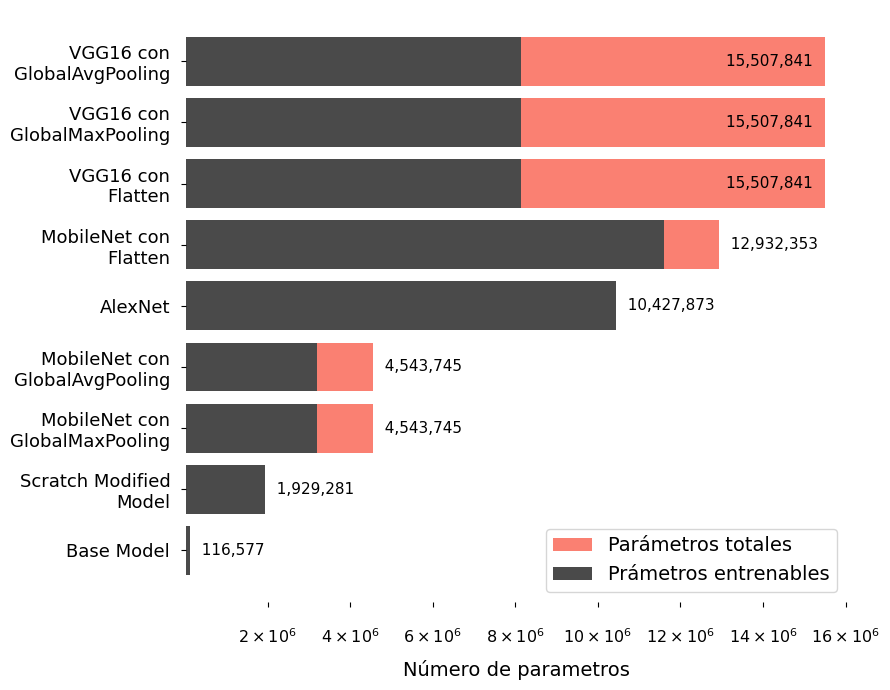

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Definición de colores personalizados
COLOR1 = 'salmon'
COLOR2 = '#4A4A4A'

# Función para formatear los ticks del eje X
def format_func(value, tick_number):
    if value == 0:
        return '0'
    # Dividir el valor por 10^6 y mostrar el multiplicador seguido de 10^6
    return r'${}\times10^6$'.format(int(value / 10**6))

# Generar la visualización de barras sin escala logarítmica
fig, ax = plt.subplots(figsize=(9, 7))  # Crear figura y ejes

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Cambiar el color de fondo de la figura y del área de la gráfica
fig.patch.set_facecolor('#ffffff')  # Fondo general de la figura
ax.set_facecolor('#ffffff')  # Fondo del área de la gráfica

# Añadimos las barras
total_bars = ax.barh(df_sorted['Nombre del modelo'], df_sorted['Numero total de parametros'], color=COLOR1, label='Parámetros totales')
trainable_bars = ax.barh(df_sorted['Nombre del modelo'], df_sorted['Parametros entrenables'], color=COLOR2, label='Prámetros entrenables')

# Ajustar el rango del eje X de 10^5 a 10^7
ax.set_xlim(10**4.5, 10**7.205)

# Aplicar el formato a los ticks del eje X
ax.xaxis.set_major_formatter(FuncFormatter(format_func))

# Cambiar el tamaño y el espaciado de los ticks del eje X y Y
ax.tick_params(axis='x', labelsize=11.5, pad=15)  # Espacio entre los valores y el eje X
ax.tick_params(axis='y', labelsize=13, pad=8)  # Espacio entre los valores y el eje Y

# Añadir los valores sobre las barras
for i, (total_bar, trainable_bar) in enumerate(zip(total_bars, trainable_bars)):
    # Para los Total params
    if i > 5:
        orientacion = 'right'
        ax.text(total_bar.get_width() + 50000, total_bar.get_y() + total_bar.get_height() / 2,
            f'{df_sorted["Numero total de parametros"][i]:,}   ', va='center', ha=orientacion, fontsize=11, color='black')
    else:
        orientacion = 'left'
        ax.text(total_bar.get_width() + 50000, total_bar.get_y() + total_bar.get_height() / 2,
                f'  {df_sorted["Numero total de parametros"][i]:,}', va='center', ha=orientacion, fontsize=11, color='black')

    # Para los Trainable params
    # ax.text(trainable_bar.get_width() + 50000, trainable_bar.get_y() + trainable_bar.get_height()/2,
    #         f'{df_sorted["Trainable params"][i]:,}', va='center', ha='left', fontsize=12, color='orange')

# Cambiar el tamaño de la leyenda y el título
ax.legend(fontsize=14)
ax.set_xlabel('Número de parametros', fontsize=14, labelpad=10)  # Espacio entre la etiqueta del eje X y el gráfico
# ax.set_title('Número de Parámetros por Modelo', fontsize=18, pad=20)  # Espacio entre el título y el gráfico

# Ajustar diseño y mostrar gráfica
plt.tight_layout()
plt.show()

## Visualización del tamaño de los modelos

In [15]:
rows = []
for elem in model_data_list:
    aux_params = []
    aux_size = []
    rows.append([elem[0]]+elem[4][3:])    
columns = ["Nombre del modelo","Tam total del modelo (MB)", "Tam entrenable (MB)", "Tam no entrenable (MB)"]
df = pd.DataFrame(rows, columns=columns)
df_sorted = df.sort_values(by="Tam total del modelo (MB)", ascending=True)
display(df_sorted)

,Nombre del modelo,Tam total del modelo (MB),Tam entrenable (MB),Tam no entrenable (MB)
0,Base Model,0.44,0.44,0.00
2,Scratch Modified Model,7.36,7.36,0.00
7,MobileNet con GlobalMaxPooling,17.33,12.24,5.09
8,MobileNet con GlobalAveragePooling,17.33,12.24,5.09
1,AlexNet,39.78,39.78,0.00
6,MobileNet con Flatten,49.33,44.24,5.09
3,VGG16 con Flatten,59.16,31.02,28.13
4,VGG16 con GlobalMaxPooling,59.16,31.02,28.13
5,VGG16 con GlobalAveragePooling,59.16,31.02,28.13


## Sampleo de los mejores hiperparámetros

In [129]:
models_data = {}
for elem in model_data_list[1:]:
    models_data[elem[0]] = elem[2][0]
df = pd.DataFrame(models_data).T

def transformar_class_weight(class_weight):
    if class_weight == {0: 1, 1: 1}:
        return "No balanceadas"
    else:
        return "Balanceadas"
    # if class_weight == {0: 0.8568438677270824, 1: 1.2005865102639297}:
    #     return {0: 0.86, 1: 1.20}
    # else:
    #     return class_weight
df["class_weight"] = df["class_weight"].apply(transformar_class_weight)

def transformar_define_callbacks(callback):
    lista_final = ""
    for elem in callback:
        if elem == "reduce_lr":
            lista_final += "reduce_lr y "
        if elem == "early_stopping":
            lista_final += "early_stopping"
    return lista_final
df["define_callbacks"] = df["define_callbacks"].apply(transformar_define_callbacks)
del df["epochs"]
del df["define_callbacks"]
del df["semilla"]


# new_row = pd.DataFrame({'class_weight': "No balancea", 'batch_size':32,	"patience early stopping":"NaN","patience reduce lr":"NaN",	'test_size':0.3},index=["Base Model"])
# df = pd.concat([new_row, df])

display(df)

,class_weight,batch_size,patience_early_stopping,patience_reduce_lr,test_size
AlexNet,Balanceadas,32,20,10,0.2
Scratch Modified Model,No balanceadas,32,20,10,0.2
VGG16 con Flatten,No balanceadas,32,14,8,0.2
VGG16 con GlobalMaxPooling,Balanceadas,32,20,NaN,0.2
VGG16 con GlobalAveragePooling,Balanceadas,32,20,10,0.2
MobileNet con Flatten,No balanceadas,16,20,10,0.3
MobileNet con GlobalMaxPooling,Balanceadas,32,20,10,0.2
MobileNet con GlobalAveragePooling,No balanceadas,32,14,NaN,0.2


# Cálculo del tiempo medio por arquitectura

In [170]:
total = np.array([])
total_base = np.array([])
for elem in os.listdir("./resultados"):
    media = np.array([])
    try:
        for txt in os.listdir("./resultados/"+elem):
            if ".txt" in txt:
                with open("./resultados/"+elem+"/"+txt, 'r') as archivo:
                    contenido = archivo.read()
                    hiperparams = ast.literal_eval(contenido)
                media = np.append(media,hiperparams[-2])
        # print(elem,round(np.mean(media)))
        if "base_model" not in elem:
            print(elem,round(np.mean(media)*48))
            total = np.append(total,np.mean(media)*48)
        else:
            print(elem,round(np.mean(media)*5))
            total_base = np.append(total,np.mean(media)*5)
    except:
        pass
print(f"Tiempo de entrenamiento de los modelos nuevos {sum(total)/60}")
print(f"Tiempo de entrenamiento del modelo base {sum(total_base)/60}")

alexnet 16849
base_model 2181
mobilenet_Flatten 7109
mobilenet_GlobalAveragePooling 6985
mobilenet_GlobalMaxPooling 9419
scratch_modified 17983
vgg_Flatten 12331
vgg_GlobalAveragePooling 13512
vgg_GlobalMaxPooling 13201
Tiempo de entrenamiento de los modelos nuevos 1623.161121631804
Tiempo de entrenamiento del modelo base 317.16684048175813
